In [1]:
from src.containers.evaluation_container import EvaluationContainer
from src.services.config.config_interface import DirConfig
from src.utils import tqdm_joblib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import japanize_matplotlib

plt.style.use("ggplot")
dir_config = DirConfig(env='local', exp='eval_proposed', debug=False)

In [3]:
coupon_type_to_color = {
    'control': '#E24A33',
    '5% back': '#348ABD',
    '5% off':'#988ED5',
    '300yen off':'#777777',  
    '10% off': '#FBC15E', 
    '10% back': '#8EBA42', 
    '15% off': '#FFB5B8'
}

In [4]:
def evaluate(exp):
    container = EvaluationContainer(exp, debug=False)
    name = container.config.base_config.name
    container.initialize()
    base_config = container.config.base_config
    config = container.config
    postprocess_config = config.postprocess_config

    n_sample = min(container.test_df.shape[0], postprocess_config.n_sample)
    random_checked = set()
    results =[]
    # self.assignments.append([name, seed, budget_constraint, assignment])
    for seed, budget_constraint, assginment in container.assignments:
        # test_dfからランダムにn_sample個のidxを取得
        sample_idx = container.test_df.sample(n_sample, random_state=seed).index.to_numpy()
        # sample_idxのデータを取得しsample_dfに格納
        sample_df = container.test_df.loc[sample_idx].copy().reset_index(drop=True)
        # target列にGMVを代入
        sample_df['target'] = sample_df[base_config.target_name]
        # sample_dfのなかで各config.treatment_nameの数をカウント
        n_treatment = sample_df[base_config.treatment_name].value_counts().to_dict()
        n_treatment_all = sum(n_treatment.values())
        # cost列にvariant_no_to_costの値を代入
        sample_df['cost'] = sample_df[base_config.treatment_name].map(postprocess_config.variant_no_to_cost)
            
        # model
        gmv = 0
        cost = 0
        for t in range(1, 7):
            gmv += sample_df['target'][(assginment==t) & (sample_df[base_config.treatment_name]==t)].sum()*(n_treatment_all/n_treatment[t])
            gmv -= sample_df['target'][(assginment==t) & (sample_df[base_config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
            cost += sample_df['cost'][(assginment==t) & (sample_df[base_config.treatment_name]==t)].sum()
            # cost -= sample_df['cost'][(assginment==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
        rate = (sample_df['target'][(assginment==sample_df[base_config.treatment_name])]!=0).mean()
        results.append([exp, name, seed, cost, gmv, rate, budget_constraint])
    return results


def split_name(name):
    return (
        name.str.split(',', expand=True)
        .iloc[:, 2:]
        .applymap(lambda x: x.split('=')[-1] if isinstance(x, str) else None)
        .astype(float)
    )

## 一番良かったExp

In [5]:
def plot_allocation(container):
    clusters = container.clusters
    assignments = container.assignments
    n_budget = len(clusters)

    # sort by budget
    cluster = sorted(clusters, key=lambda x: x[1])[0][-1]
    assignments = sorted(assignments, key=lambda x: x[1])

    # plot
    fig, axes = plt.subplots(n_budget, 1, figsize=(20, 5 * n_budget))
    for i, (assignment) in enumerate(assignments):
        budget_constraint = assignment[1]
        assignment = assignment[-1]

        df = pd.DataFrame({'cluster': cluster, 'assignment': assignment})
        df = df.sort_values('assignment', ascending=False)
        df = df.groupby(['cluster', 'assignment']).size().reset_index().sort_values('assignment')
        df = df.pivot(index='cluster', columns='assignment', values=0).fillna(0)
        df.columns = list(map(lambda x: container.config.base_config.counpon_config.variant_no_to_coupon_type[x], df.columns))
        (
            df.plot.bar(
                stacked=True, 
                ax=axes[i], 
                legend=True, 
                title=f'budget constraint={budget_constraint:.0f}',
                color=coupon_type_to_color
            )
        )
        axes[i].set_ylabel('クラスターサイズ', fontsize=25)
        axes[i].set_xlabel('クラスター番号', fontsize=25)
    
    fig.tight_layout()

    return fig, axes

def plot_cluster(container):
    cluster = container.clusters[0][-1]
    uplift = container.uplift_pred
    columns = list(container.config.base_config.counpon_config.variant_no_to_coupon_type.values())[1:]
    uplift.columns = columns

    fig, axes = plt.subplots(2, 1, figsize=(20, 5*2), sharey=True, sharex=False)

    # mean uplift
    uplift.groupby(cluster).sum().plot.bar(stacked=True, 
                                           ax=axes[0], 
                                           color=coupon_type_to_color
                                           )
    # std uplift
    uplift.groupby(cluster).std().plot.bar(stacked=True, ax=axes[1], color=coupon_type_to_color)

    axes[0].set_ylabel('平均Uplift', fontsize=25)
    axes[1].set_ylabel('標準偏差', fontsize=25)
    axes[0].set_xlabel('クラスター番号', fontsize=25)
    axes[1].set_xlabel('クラスター番号', fontsize=25)
    fig.tight_layout()

    return fig, axes

In [6]:
container = EvaluationContainer('optimize205', debug=False)
container.initialize()

[EvaluationContainer 2022-12-31 15:08:43] INFO Setup [EvaluationContainer]
[ConfigService 2022-12-31 15:08:43] INFO Setup [ConfigService]
[ConfigService 2022-12-31 15:08:43] INFO {'root_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research')}
[ConfigService 2022-12-31 15:08:43] INFO {'input_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/input')}
[ConfigService 2022-12-31 15:08:43] INFO {'output_root': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/output/optimize205')}
[ConfigService 2022-12-31 15:08:43] INFO {'output_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/output/optimize205/outputs')}
[ConfigService 2022-12-31 15:08:43] INFO {'output_prediction_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/output/optimize205/predictions')}
[ConfigService 2022-12-31 15:08:43] INFO {'output_model_dir': PosixPath('/Users/tsukuba-yuuki-u

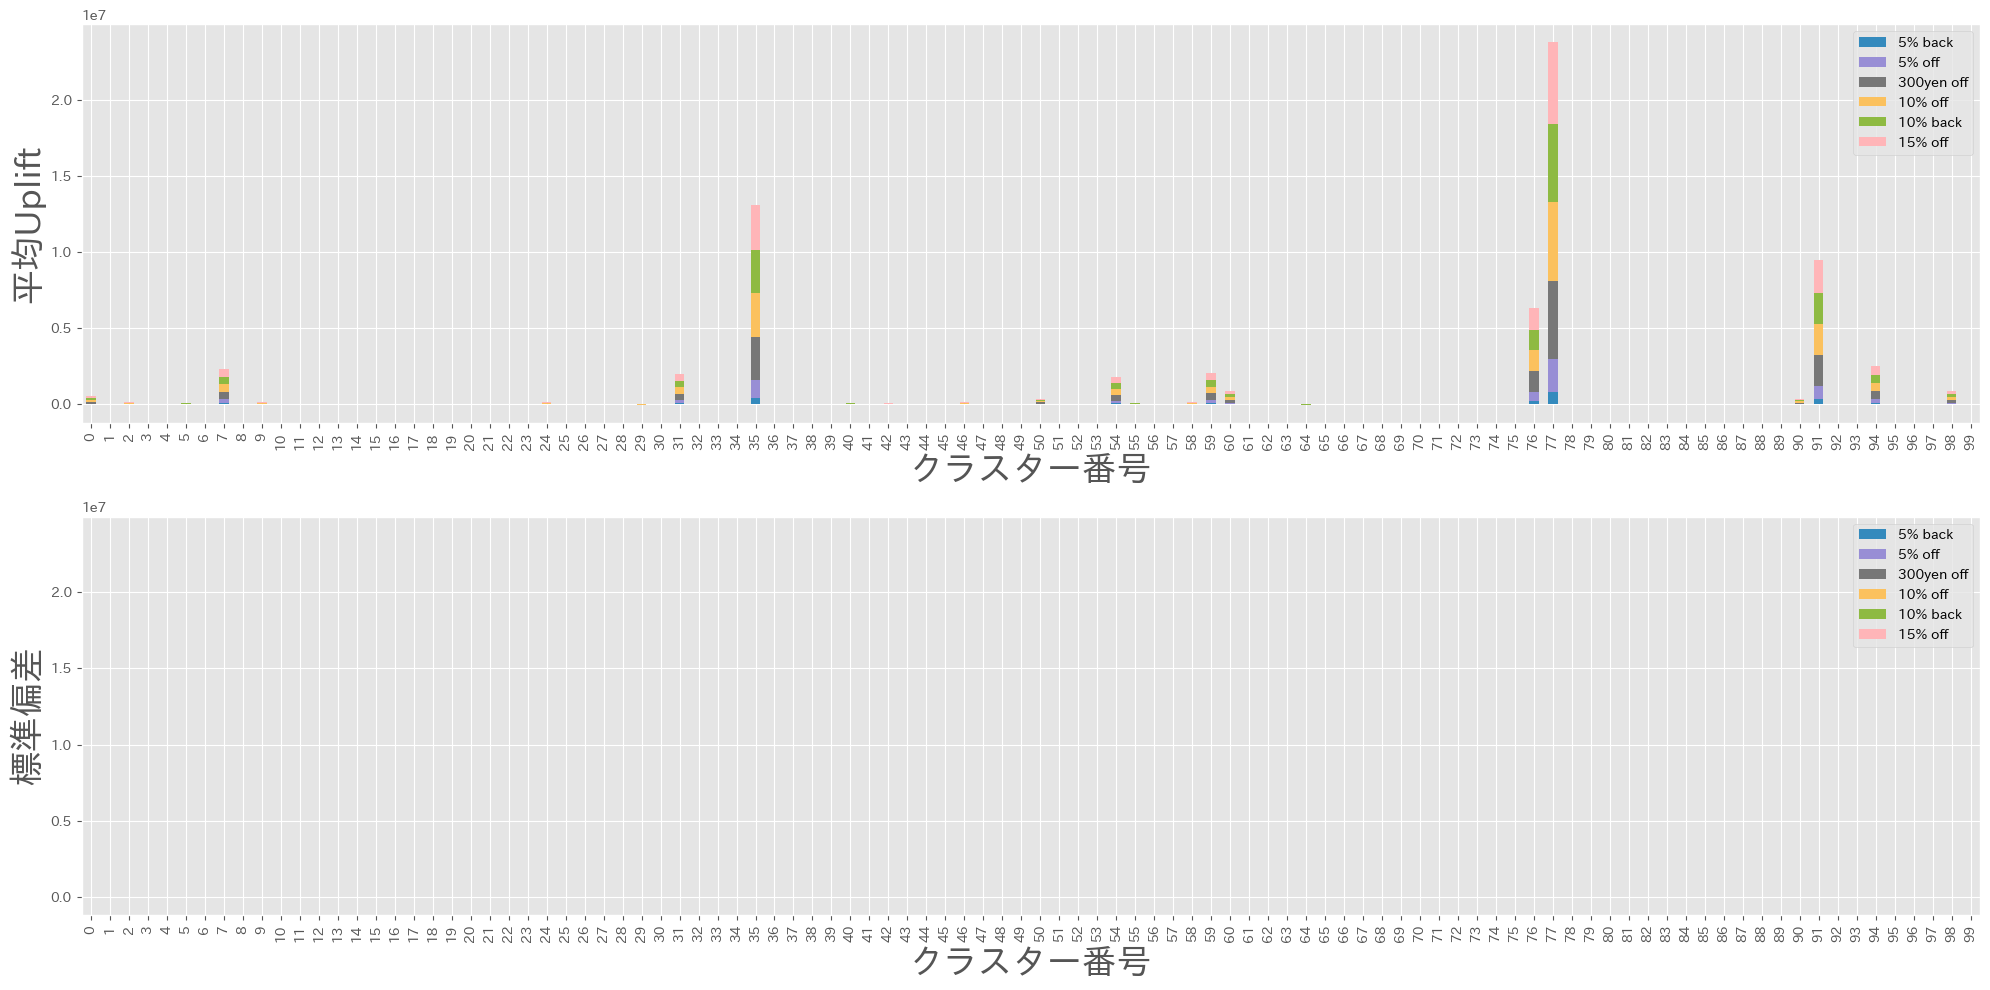

In [10]:
fig, axes = plot_cluster(container)

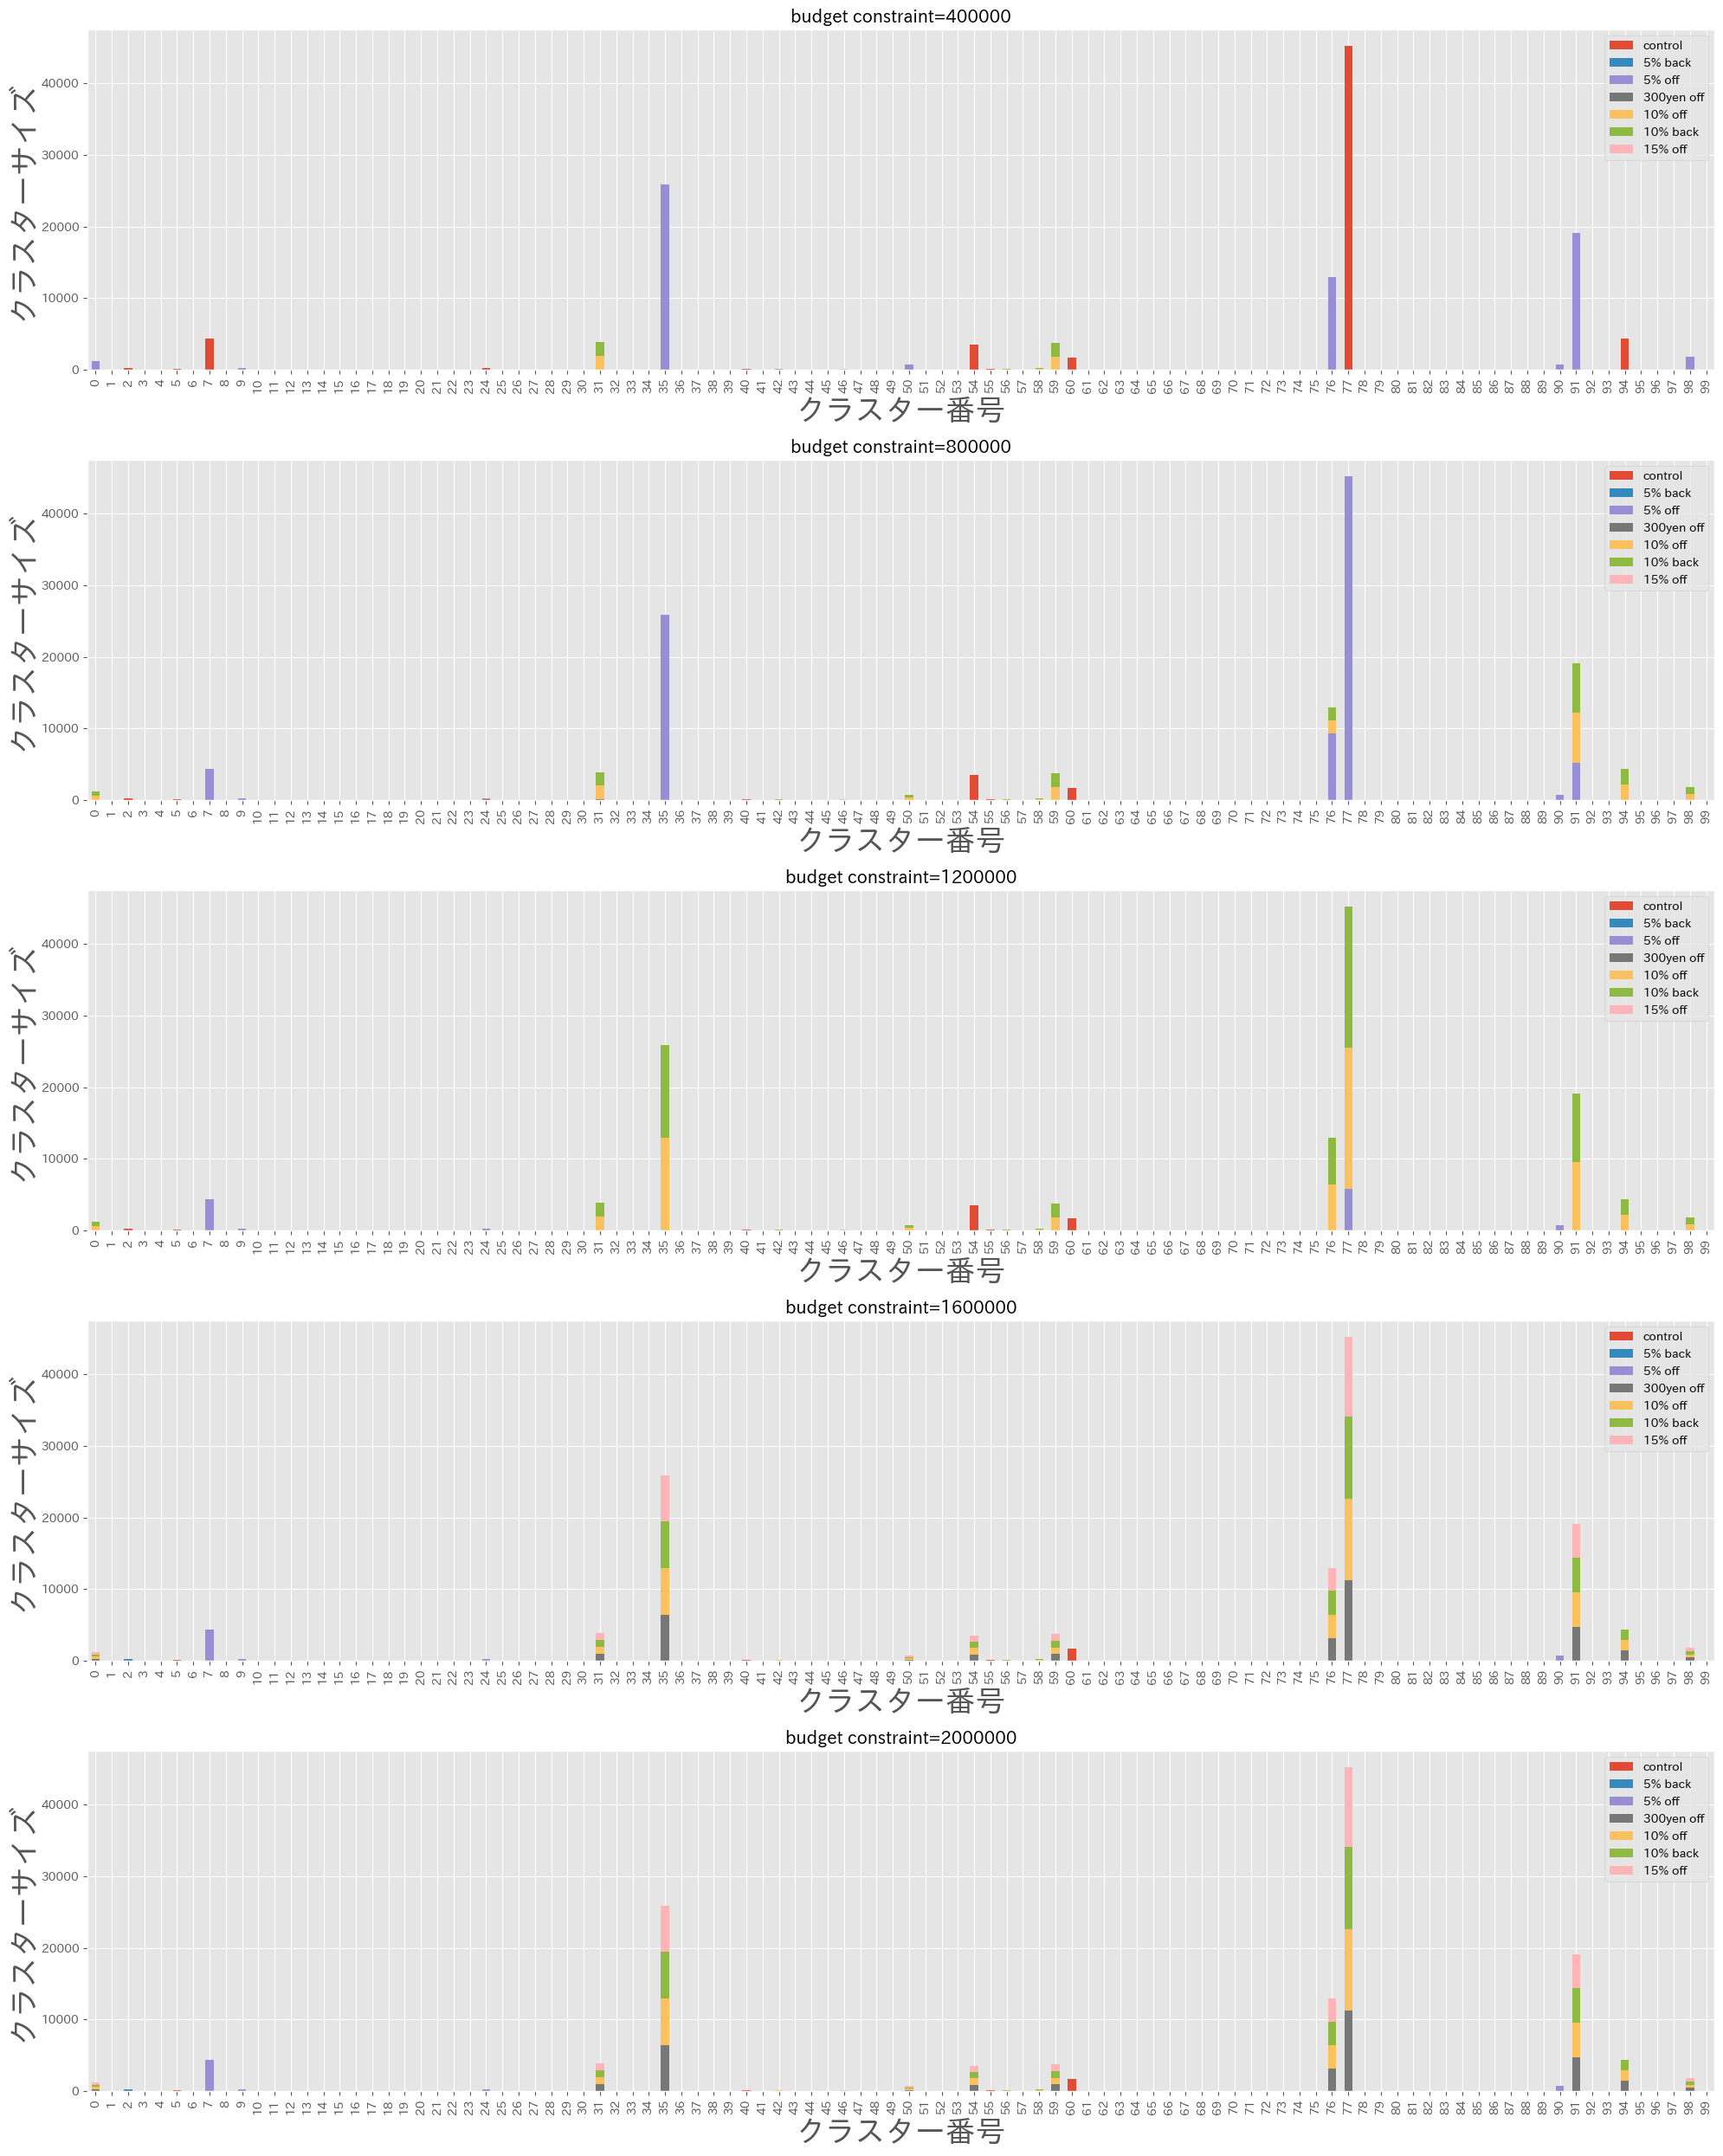

In [11]:
fig, axes = plot_allocation(container)
fig.savefig(dir_config.output_figure_dir / 'allocation.png')

## ハイパーパラメータによる精度変化

In [13]:
results = []
exps = [f'optimize{i:03}' for i in range(126, 206)]
num_cores = multiprocessing.cpu_count()
with tqdm_joblib(len(exps)):
    results = Parallel(n_jobs=num_cores)([delayed(evaluate)(exp) for exp in exps])

# flatten
results = [item for sublist in results for item in sublist]

result_df = pd.DataFrame(results, columns=['exp', 'name', 'seed', 'cost', 'GMV', 'assign_rate', 'budget_constraint'])
result_df['cost'] = result_df['cost'].astype(int)
result_df = result_df.drop_duplicates().reset_index(drop=True)
result_df['random'] = result_df['name'] == 'random'
result_df = result_df.sort_values(['random', 'name','cost','seed'])
result_df['sum_GMV'] = result_df.groupby('name')['GMV'].transform('sum')

100%|██████████| 80/80 [01:46<00:00,  1.33s/it]


In [34]:
agg_df = result_df.groupby(['name'])['GMV'].sum().reset_index()
agg_df[['alpha', 'cluster', 'gamma']] = split_name(agg_df['name'])
agg_df['beta'] = agg_df['gamma'] / (agg_df['cluster']*5)
agg_df = agg_df.rename(columns={'GMV': 'Total_GMV'})
# agg_df = agg_df.query('alpha==1').reset_index(drop=True)

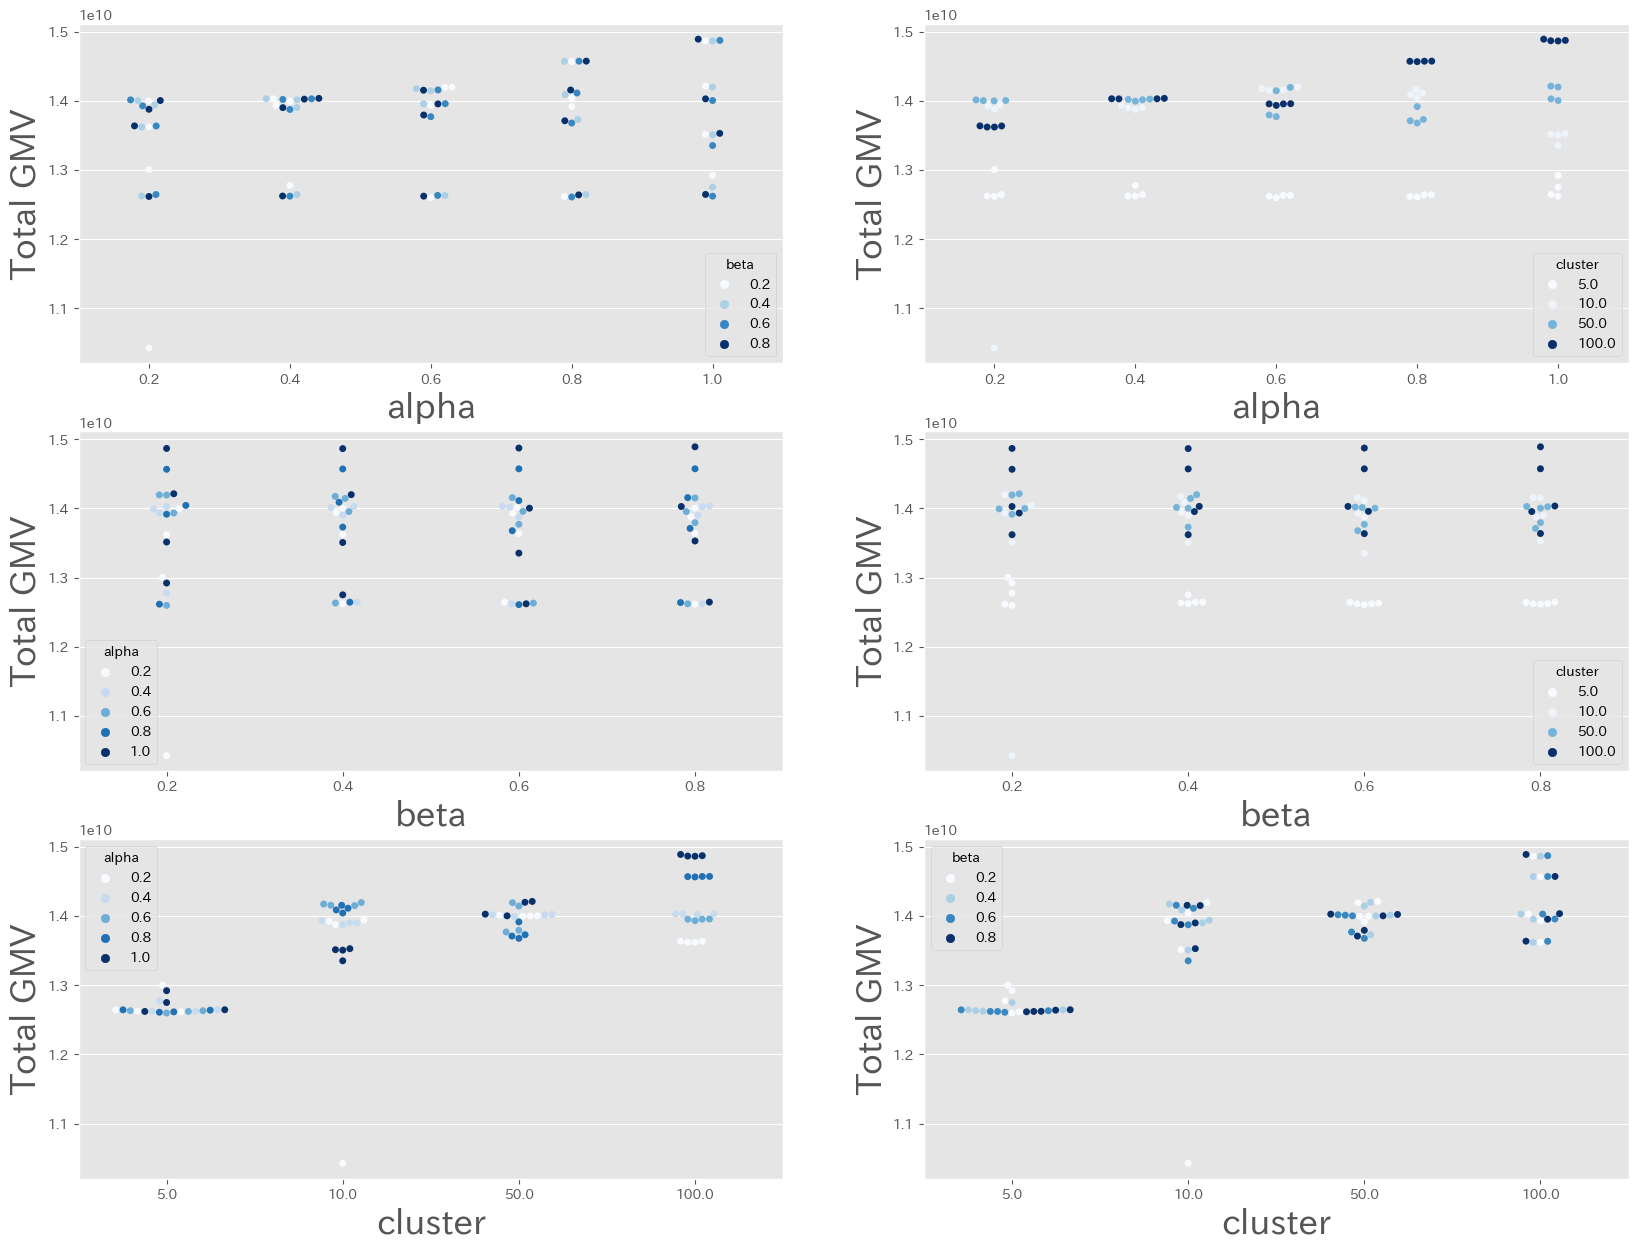

In [35]:
params =  ['alpha', 'beta', 'cluster']
fig, axes = plt.subplots(3, 2, figsize=(10*2, 5*3))
axes = axes.flatten()
i = 0
for x in params:
    for hue in [param for param in params if param != x]:
        ax = axes[i]
        sns.swarmplot(x=agg_df[x], y=agg_df['Total_GMV'], hue=agg_df[hue], palette='Blues', ax=ax)
        ax.set_xlabel(x, fontsize=25)
        ax.set_ylabel('Total GMV', fontsize=25)

        i += 1